In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('master_df.csv', index_col='created_at')
df.index = pd.to_datetime(df.index, unit='s')
df.head()

,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,creator,currency,currency_symbol,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type
created_at,,,,,,,,,,,,,,,,,,,,,
2020-12-31 01:00:06,0,18,A cookbook for lyke minded poeple who love sim...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",5034,US,the United States,"{""id"":1076439302,""name"":""Ali"",""slug"":""lykemind...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1611968831,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,5034.000000,international
2020-11-25 04:29:20,1,508,A cookbook filled with memoirs and recipes fro...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",48365,HK,Hong Kong,"{""id"":974771323,""name"":""Peggy Chan"",""slug"":""ch...",HKD,$,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1614096106,0.128984,"{""web"":{""project"":""https://www.kickstarter.com...",0.128976,48368.291331,international
2020-11-27 11:38:16,2,14,Zine de libro de recetas para estudiantes,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",98,ES,Spain,"{""id"":1376613464,""name"":""Asociación Trece Aran...",EUR,€,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1607900340,1.196375,"{""web"":{""project"":""https://www.kickstarter.com...",1.211149,96.906412,international
2020-11-04 14:41:45,3,1486,"A Chef's Guide to Hunting, Preparing and Cooki...","{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",127765,US,the United States,"{""id"":365711508,""name"":""Jesse Griffiths"",""slug...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1610082068,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,127765.690000,international
2020-11-15 15:38:47,4,249,A selection of the recipes we love from the co...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",14574,GB,the United Kingdom,"{""id"":349330105,""name"":""Eilis and Emma"",""slug""...",GBP,£,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1608573895,1.327616,"{""web"":{""project"":""https://www.kickstarter.com...",1.336255,14480.304767,international


In [9]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,creator,currency,currency_symbol,currency_trailing_code,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type
created_at,,,,,,,,,,,,,,,,,,,,,
2020-12-31 01:00:06,18,A cookbook for lyke minded poeple who love sim...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",5034,US,the United States,"{""id"":1076439302,""name"":""Ali"",""slug"":""lykemind...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1611968831,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,5034.000000,international
2020-11-25 04:29:20,508,A cookbook filled with memoirs and recipes fro...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",48365,HK,Hong Kong,"{""id"":974771323,""name"":""Peggy Chan"",""slug"":""ch...",HKD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1614096106,0.128984,"{""web"":{""project"":""https://www.kickstarter.com...",0.128976,48368.291331,international
2020-11-27 11:38:16,14,Zine de libro de recetas para estudiantes,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",98,ES,Spain,"{""id"":1376613464,""name"":""Asociación Trece Aran...",EUR,€,False,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1607900340,1.196375,"{""web"":{""project"":""https://www.kickstarter.com...",1.211149,96.906412,international
2020-11-04 14:41:45,1486,"A Chef's Guide to Hunting, Preparing and Cooki...","{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",127765,US,the United States,"{""id"":365711508,""name"":""Jesse Griffiths"",""slug...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1610082068,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,127765.690000,international
2020-11-15 15:38:47,249,A selection of the recipes we love from the co...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",14574,GB,the United Kingdom,"{""id"":349330105,""name"":""Eilis and Emma"",""slug""...",GBP,£,False,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1608573895,1.327616,"{""web"":{""project"":""https://www.kickstarter.com...",1.336255,14480.304767,international


In [62]:
from ast import literal_eval

categories = df.category.apply(literal_eval).to_frame()
categories = pd.json_normalize(categories.category)
categories


,id,name,analytics_name,slug,position,parent_id,parent_name,color,urls.web.discover
0,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
1,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
2,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
3,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
4,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
...,...,...,...,...,...,...,...,...,...
30987,51,Software,Software,technology/software,11,16.0,Technology,6526716,http://www.kickstarter.com/discover/categories...
30988,51,Software,Software,technology/software,11,16.0,Technology,6526716,http://www.kickstarter.com/discover/categories...
30989,51,Software,Software,technology/software,11,16.0,Technology,6526716,http://www.kickstarter.com/discover/categories...
30990,285,Plays,Plays,theater/plays,6,17.0,Theater,16743775,http://www.kickstarter.com/discover/categories...


In [19]:
working_df = df[['goal', 'pledged', 'state']]
working_df.head()

,goal,pledged,state
created_at,,,
2020-12-31 01:00:06,5000.0,5034.00,successful
2020-11-25 04:29:20,350000.0,374995.00,successful
2020-11-27 11:38:16,50.0,81.00,successful
2020-11-04 14:41:45,65000.0,127765.69,successful
2020-11-15 15:38:47,10600.0,10907.00,successful


In [20]:
working_df.sample(20)

,goal,pledged,state
created_at,,,
2021-01-07 23:54:16,300.0,1.29,failed
2019-05-08 02:40:23,7500.0,9851.42,successful
2017-02-04 21:48:27,50000.0,0.00,failed
2018-07-26 04:05:09,2000.0,2101.00,successful
2020-05-10 23:27:33,10000.0,101.00,failed
2021-06-22 04:26:05,30000.0,283342.00,successful
2019-09-10 22:36:41,4000.0,152.00,failed
2015-09-04 19:06:04,65000.0,20.00,failed
2021-11-22 05:56:22,2000.0,32356.00,successful


In [38]:
working_df['percentage_funded'] = working_df.pledged/working_df.goal*100

/Users/stuartperry/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
working_df

,goal,pledged,state,percentage_funded
created_at,,,,
2020-12-31 01:00:06,5000.0,5034.00,successful,100.680000
2020-11-25 04:29:20,350000.0,374995.00,successful,107.141429
2020-11-27 11:38:16,50.0,81.00,successful,162.000000
2020-11-04 14:41:45,65000.0,127765.69,successful,196.562600
2020-11-15 15:38:47,10600.0,10907.00,successful,102.896226
...,...,...,...,...
2021-09-26 17:45:30,10000.0,501.00,failed,5.010000
2021-09-27 07:00:42,50000.0,1.29,failed,0.002580
2021-09-13 07:22:30,1000000.0,6.17,failed,0.000617


<AxesSubplot:xlabel='created_at'>

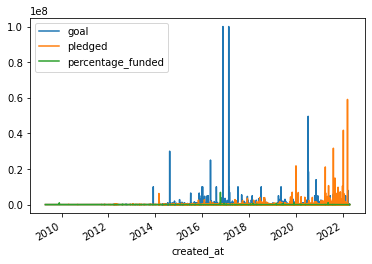

In [44]:
working_df.sort_values(by='percentage_funded', ascending=False).plot()

In [45]:
working_df.sort_values(by='percentage_funded', ascending=False)

,goal,pledged,state,percentage_funded
created_at,,,,
2016-10-11 23:14:53,1.00,68764.1,successful,6876410.0
2021-05-18 02:37:11,1.00,10834.0,successful,1083400.0
2009-11-25 06:07:11,0.01,100.0,successful,1000000.0
2019-12-03 16:00:23,1.00,9935.0,successful,993500.0
2016-12-05 20:08:39,1.00,7529.0,successful,752900.0
...,...,...,...,...
2017-09-22 20:06:27,75000.00,0.0,failed,0.0
2016-11-21 14:48:11,600.00,0.0,failed,0.0
2017-07-19 20:44:11,5000.00,0.0,failed,0.0


<AxesSubplot:xlabel='created_at'>

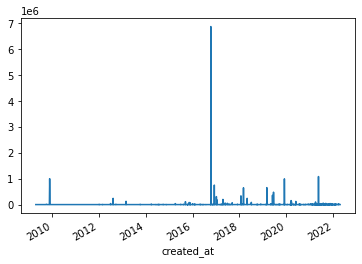

In [43]:
working_df['percentage_funded'].plot()

<AxesSubplot:xlabel='state'>

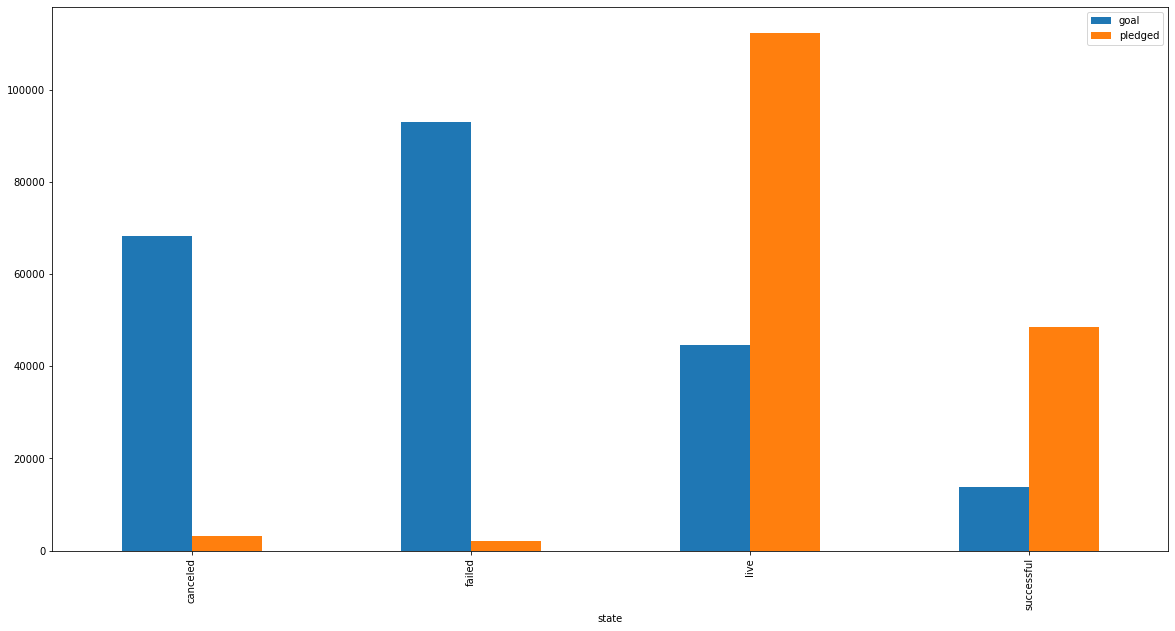

In [34]:
working_df.groupby('state').mean().plot.bar(figsize=(20,10), sharex=True)